In [21]:
import pandas as pd
import ta
from binance.client import Client
import ccxt
import mplfinance as mpf
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import config

client = Client(config.api_key, config.api_secret)
# Create Binance client instance
exchange = ccxt.binance({
    'apiKey': config.api_key,
    'secret': config.api_secret,
})

In [22]:
# barcha balanslarni korsatadi
# info = client.get_account()
# balans = info['balances']
# for x in balans:
#     if float(x['free']) > 0:
#         print(x)

In [23]:
balance = client.get_asset_balance(asset='USDT')
balance # USDT ga tegishgli balansni korsatadi

{'asset': 'USDT', 'free': '0.39314268', 'locked': '0.00000000'}

In [26]:
# Get latest bitcoin price
btc_price = client.get_symbol_ticker(symbol="BNBUSDT")

# Print the price
print("Bitcoin price: ", btc_price['price'])


Bitcoin price:  322.30000000


In [27]:
# Define symbol and interval
symbol = 'BNBUSDT'
interval = Client.KLINE_INTERVAL_1HOUR

# fetch 30 minute klines for the last month of 2017
klines = client.get_historical_klines(symbol, interval) #, "1 Yan, 2023", "1 Jan, 2025") # vergul qoyib tugash nuqtasini yosa ham boladi , "1 Jan, 2018")

# Convert klines to pandas dataframe
data = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Convert timestamp to datetime format
data.index = pd.to_datetime(data.index, unit='ms')
# data.close_time = pd.to_datetime(data.close_time, unit='ms')

# data type converse float
df = data[['open', 'high', 'low', 'close', 'volume']].astype(float)

data.iloc[-1] # oxirgi narx

open                               322.00000000
high                               322.30000000
low                                321.90000000
close                              322.30000000
volume                            1683.34400000
close_time                        1682798399999
quote_asset_volume              542095.64660000
number_of_trades                           1826
taker_buy_base_asset_volume        921.37200000
taker_buy_quote_asset_volume    296742.92370000
ignore                                        0
Name: 2023-04-29 19:00:00, dtype: object

In [28]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

bnb_macd = get_macd(df['close'], 26, 12, 9)
bnb_macd

,macd,signal,hist
timestamp,,,
2023-03-19 03:00:00,0.000000,0.000000,0.000000
2023-03-19 04:00:00,-0.103704,-0.020741,-0.082963
2023-03-19 05:00:00,-0.080068,-0.032606,-0.047461
2023-03-19 06:00:00,-0.028728,-0.031830,0.003103
2023-03-19 07:00:00,0.147435,0.004023,0.143413
...,...,...,...
2023-04-29 15:00:00,-0.570866,-0.729352,0.158486
2023-04-29 16:00:00,-0.503386,-0.684158,0.180773
2023-04-29 17:00:00,-0.588370,-0.665001,0.076631


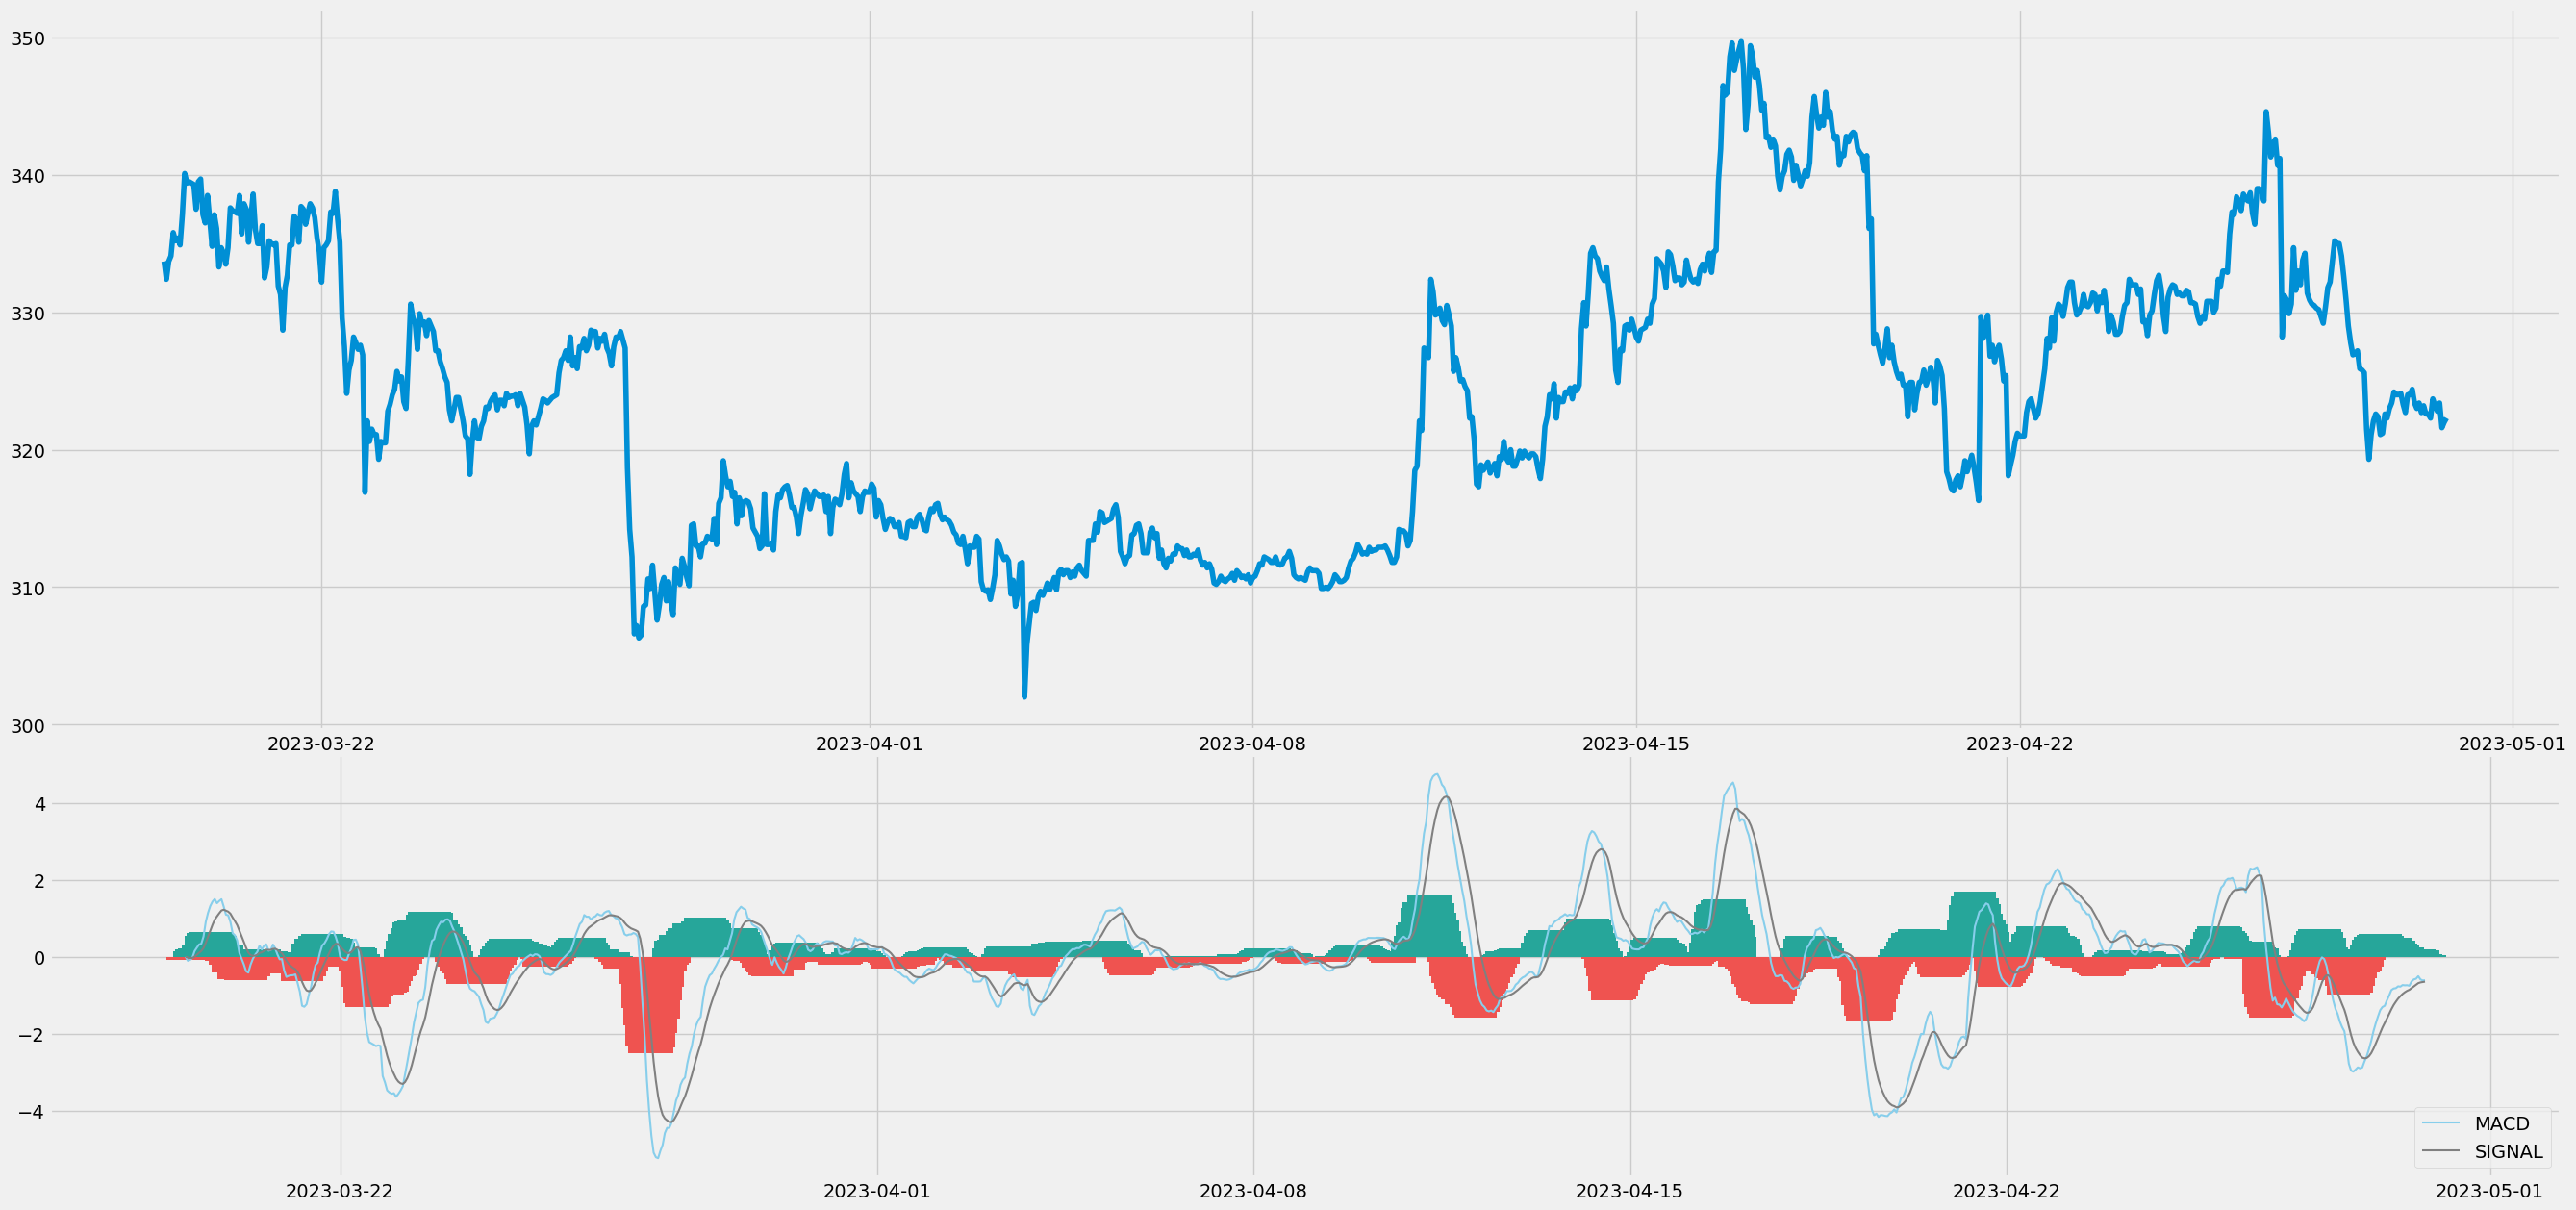

In [29]:
plt.rcParams['figure.figsize'] = (30, 15)
plt.style.use('fivethirtyeight')
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'skyblue', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'grey', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], bnb_macd['macd'], bnb_macd['signal'], bnb_macd['hist'])

In [30]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):

        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)

        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], bnb_macd)

In [31]:
signals = pd.DataFrame({"buy_price": buy_price, "sell_price": sell_price, "macd_signal": macd_signal})
signals

,buy_price,sell_price,macd_signal
0,NaN,NaN,0
1,NaN,332.4,-1
2,NaN,NaN,0
3,334.1,NaN,1
4,NaN,NaN,0
...,...,...,...
995,NaN,NaN,0
996,NaN,NaN,0
997,NaN,NaN,0
998,NaN,NaN,0


In [32]:
ta.trend.macd(df.close).iloc[-1], ta.trend.macd_signal(df.close).iloc[-1], bnb_macd.iloc[-1]

(-0.6072961912213373,
 -0.645673854272703,
 macd     -0.607296
 signal   -0.645674
 hist      0.038378
 Name: 2023-04-29 19:00:00, dtype: float64)

In [50]:
def klines(symbol):
    df = pd.DataFrame(client.get_historical_klines(symbol, '1h', '26h UTC'))
    # df = pd.DataFrame(client.get_historical_klines(symbol, '1m', '40m UTC'))
    df = df.iloc[:,:6]
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df.set_index('Time')
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)
    return df

In [51]:
df1 = klines("BNBUSDT")

In [52]:
df1.iloc[-1]

Open       322.000
High       322.800
Low        321.900
Close      322.600
Volume    2527.414
Name: 2023-04-29 19:00:00, dtype: float64

In [54]:
df1

,Open,High,Low,Close,Volume
Time,,,,,
2023-04-28 18:00:00,322.2,323.0,321.4,323.0,9993.205
2023-04-28 19:00:00,322.9,323.8,322.6,323.4,10889.353
2023-04-28 20:00:00,323.3,324.7,323.3,324.2,8309.795
2023-04-28 21:00:00,324.3,324.9,323.8,324.0,9672.038
2023-04-28 22:00:00,324.1,324.6,323.9,324.0,6924.366
2023-04-28 23:00:00,324.0,324.9,323.8,324.1,8748.923
2023-04-29 00:00:00,324.1,324.1,322.8,323.3,9783.030
2023-04-29 01:00:00,323.2,323.3,321.7,322.7,21038.797
2023-04-29 02:00:00,322.7,324.2,322.6,324.0,10273.716
